<a href="https://colab.research.google.com/github/rant95/Dog_breed_classification/blob/main/Dog_Breed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Classification


---
Lova Rantoanison


---
Juin 2019


#*1*.Introduction

The objectif is to predict the breed of a dog given an input image of a dog . We take only the breed's Top 30

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/dog/
!ls

!unzip train.zip

#*2*.Loading Dataset

In [ ]:
#import the neccesary packages
import pandas as pd
import numpy as np
from random import randint
from tqdm import tqdm
import cv2
#constants
num_classes = 80 # the number of breeds we want to classify
seed = 42 # makes the random numbers in numpy predictable
im_size = 299 # This size of the images
batch_size = 32
path = '/content/drive/My Drive/Colab Notebooks/dog/'
#read the csv into a dataframe, group the breeds and 
df = pd.read_csv(path+'labels.csv')



In [ ]:
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
selected_breed_list
df = df[df['breed'].isin(selected_breed_list)]
df['filename'] = df.apply(lambda x: ('train/' + x['id'] + '.jpg'), axis=1)


breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

df.head()

total number of breeds to classify 80


,id,breed,filename
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,train/002211c81b498ef88e1b40b9abf84e1d.jpg
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,train/00290d3e1fdd27226ba27a8ce248ce85.jpg


In [ ]:
print(df.groupby('breed').count().sort_values(by='id', ascending=False))

breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

                            id  filename
breed                                   
scottish_deerhound         126       126
maltese_dog                117       117
afghan_hound               116       116
entlebucher                115       115
bernese_mountain_dog       114       114
...                        ...       ...
toy_terrier                 79        79
miniature_poodle            79        79
staffordshire_bullterrier   79        79
sussex_spaniel              78        78
norwich_terrier             78        78

[80 rows x 2 columns]
total number of breeds to classify 80


## Breed TOP 30

                             id  filename
breed                                    
weimaraner                   85        85
labrador_retriever           84        84
saint_bernard                84        84
norfolk_terrier              83        83
chesapeake_bay_retriever     83        83
english_setter               83        83
scotch_terrier               82        82
wire-haired_fox_terrier      82        82
yorkshire_terrier            82        82
kerry_blue_terrier           82        82
irish_terrier                82        82
groenendael                  82        82
greater_swiss_mountain_dog   82        82
basset                       82        82
malamute                     81        81
keeshond                     81        81
west_highland_white_terrier  81        81
gordon_setter                81        81
affenpinscher                80        80
dingo                        80        80
mexican_hairless             80        80
clumber                      80   

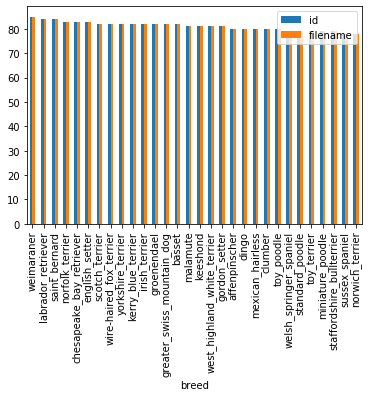

In [ ]:
print(df.groupby("breed").count().sort_values("id", ascending=False).tail(30))
df.groupby("breed").count().sort_values("id", ascending=False).tail(30).plot(kind='bar')

#*3*. Basic Visualization

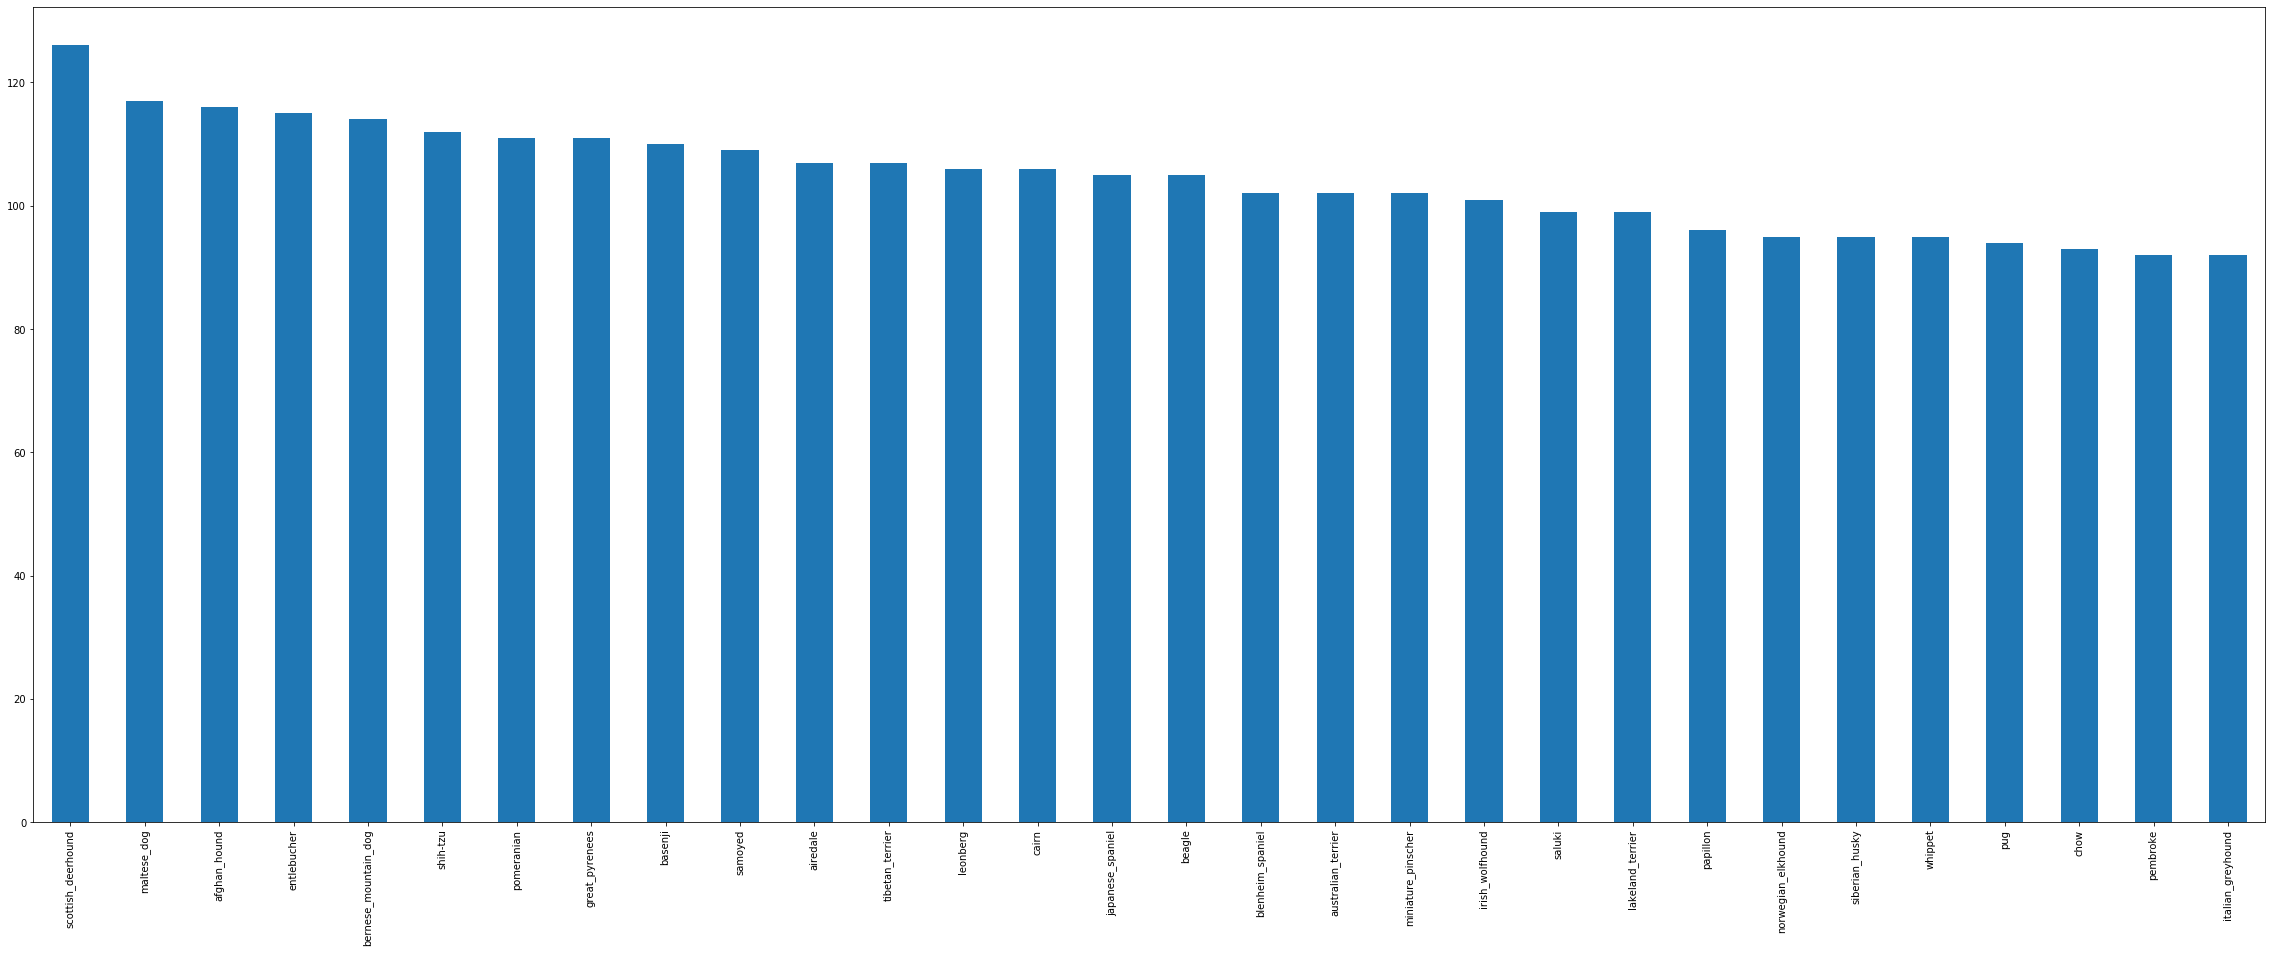

In [ ]:
top_30=list(df.breed.value_counts()[0:30].index)
plt.figure(figsize=(40,15))
df.breed.value_counts()[0:30].plot(kind='bar')
plt.show()

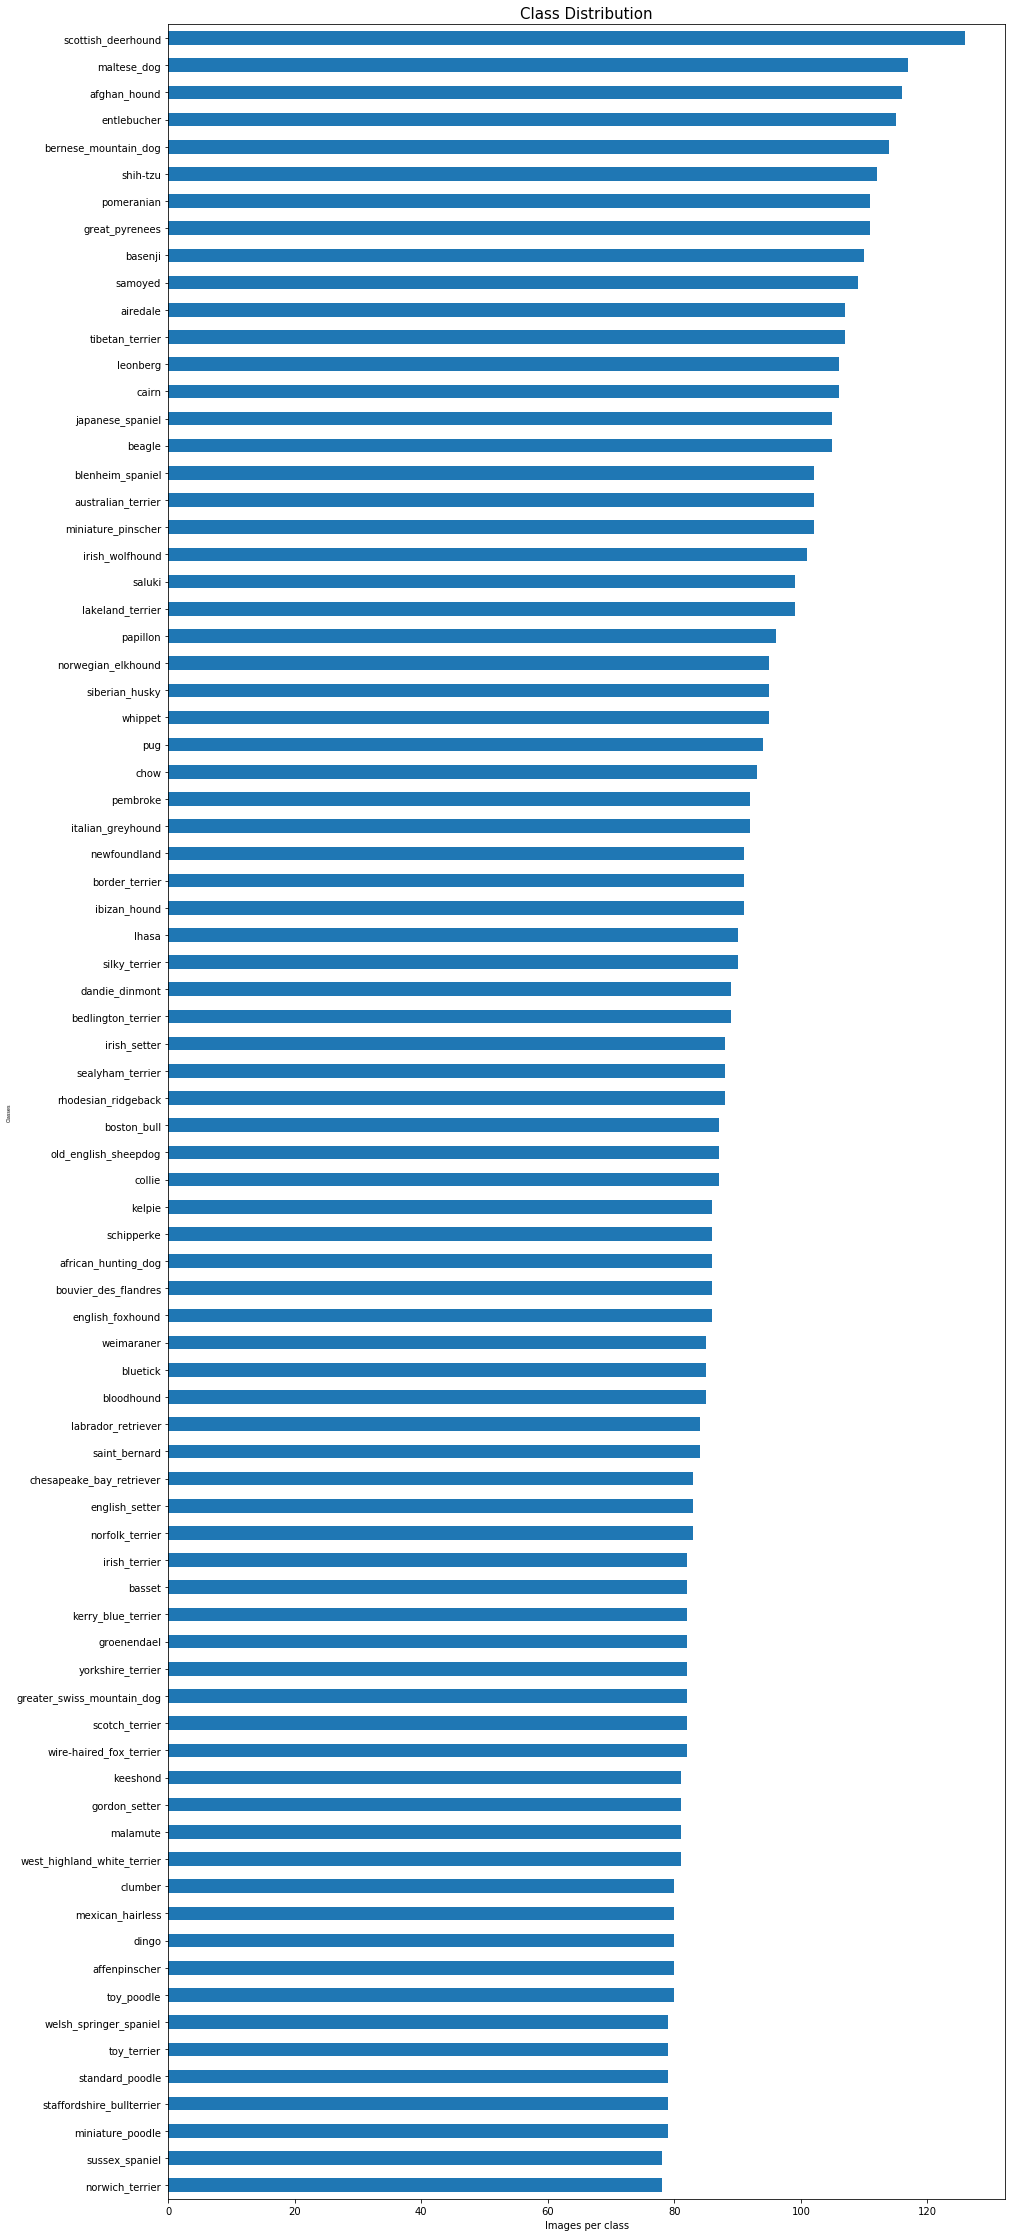

In [ ]:
ax=pd.value_counts(df['breed'],ascending=True).plot(kind='barh',
                                                       fontsize="10",
                                                       title="Class Distribution",
                                                       figsize=(15,40))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(5)
ax.title.set_size(15)

In [ ]:
def plot_images(images, classes):
    assert len(images) == len(classes) == 9
    img_width1 = 250
    img_height1 = 250
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(10,10),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.

        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB).reshape(img_width1,img_height1,3), cmap='hsv')
        xlabel = "Breed: {0}".format(classes[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(10)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.

In [ ]:
img_width1 = 250
img_height1 = 250
images=[]
classes=[]
image_dir = '/content/drive/My Drive/Colab Notebooks/dog/train/'
#load training images
for f, breed in tqdm(df.values):
    img = cv2.imread(image_dir+'{}.jpg'.format(f))
    classes.append(breed)
    images.append(cv2.resize(img, (img_width1, img_height1)))

100%|██████████| 10222/10222 [25:13<00:00,  6.75it/s]


[7822, 5216, 3108, 8080, 2889, 4957, 9568, 3949, 8472]
['lhasa', 'chihuahua', 'welsh_springer_spaniel', 'boston_bull', 'ibizan_hound', 'black-and-tan_coonhound', 'mexican_hairless', 'samoyed', 'great_dane']
Images to show: 9
Classes to show: 9


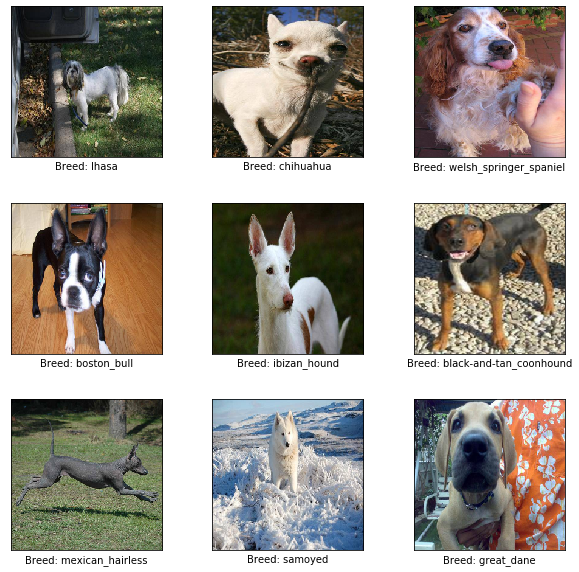

In [ ]:
# select random images
random_numbers = [randint(0, len(images)) for p in range(0,9)]
images_to_show = [images[i] for i in random_numbers]
classes_to_show = [classes[i] for i in random_numbers]
print(random_numbers)
#print(images_to_show)
print(classes_to_show)
print("Images to show: {0}".format(len(images_to_show)))
print("Classes to show: {0}".format(len(classes_to_show)))

#plot the images
plot_images(images_to_show, classes_to_show)

#4.Train test Split

In [ ]:
from keras.preprocessing import image

def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    path =  train_or_test + "/" + img_id + ".jpg"
    img = image.load_img(path, target_size=size)
    return image.img_to_array(img)

Using TensorFlow backend.


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
np.random.seed(seed=seed)
rnd = np.random.random(len(df))
train_idx = rnd < 0.9
valid_idx = rnd >= 0.9
y_train = label_enc.fit_transform(df["breed"].values)
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [ ]:
from tqdm import tqdm
from keras.applications import xception

x_train = np.zeros((train_idx.sum(), im_size, im_size, 3), dtype='float32')
x_valid = np.zeros((valid_idx.sum(), im_size, im_size, 3), dtype='float32')
train_i = 0
valid_i = 0
for i, img_id in tqdm(enumerate(df['id'])):
    img = read_img(img_id, path +'train', (im_size, im_size))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    if train_idx[i]:
        x_train[train_i] = x
        train_i += 1
    elif valid_idx[i]:
        x_valid[valid_i] = x
        valid_i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

7323it [57:46,  2.03it/s]

Train Images shape: (6595, 299, 299, 3) size: 1,768,798,785


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x_train, 
                                     ytr, 
                                     batch_size=batch_size)


valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow(x_valid, 
                                     yv, 
                                     batch_size=batch_size)


## The model of prediction Convolutional Network

In [ ]:

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer and set it to the number of breeds we want to classifiy, 
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)













83689472/83683744 [==============================] - 3s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

## Training of the model

In [ ]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 10
learning_rate = 0.001

# checkpoints
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=False,
                                  verbose=1)



# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=learning_rate, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_idx.sum() // batch_size,
                           epochs=epochs, callbacks=[early_stopping, model_checkpoint],
                           validation_data=valid_generator,
                           validation_steps=valid_idx.sum() // batch_size)

# serialize weights to HDF5
model.save(path+bst_model_path)
print("Saved model to disk")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
206/206 [==============================] - 145s 705ms/step - loss: 1.3295 - acc: 0.6633 - val_loss: 0.2729 - val_acc: 0.9219

Epoch 00001: val_loss improved from inf to 0.27287, saving model to 2019-11-18_dog_breed_model.h5
Epoch 2/10
206/206 [==============================] - 140s 681ms/step - loss: 0.9119 - acc: 0.7695 - val_loss: 0.2868 - val_acc: 0.9195

Epoch 00002: val_loss did not improve from 0.27287
Epoch 3/10
206/206 [==============================] - 139s 675ms/step - loss: 0.8865 - acc: 0.7810 - val_loss: 0.3136 - val_acc: 0.9109

Epoch 00003: val_loss did not improve from 0.27287
Epoch 4/10
206/206 [==============================] - 139s 675ms/step - loss: 0.8500 - acc: 0.7892 - val_loss: 0.2910 - val_acc: 0.9239

Epoch 00004: val_loss did not improve from 0.27287
Epoch 5/10
206/206 [==============================] - 139s 676ms/step - loss: 0.8509 - acc: 0.7893 - va

#5.Results Accuracy & Loss

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


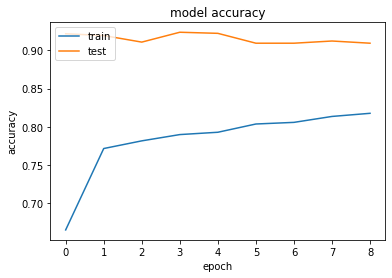

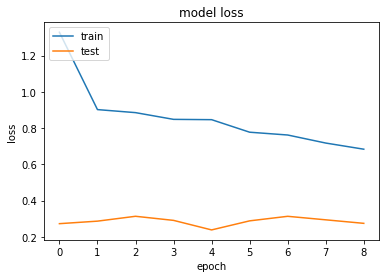

In [ ]:
import matplotlib.pyplot as plt
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def predict_from_image(img_path):

    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    pred = model.predict(img_tensor)
    sorted_breeds_list = sorted(selected_breed_list)
    predicted_class = sorted_breeds_list[np.argmax(pred)]
    
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return predicted_class

#6.Test prediction image Dog

--2019-11-18 16:53:41--  https://www.dogbreedslist.info/uploads/allimg/dog-pictures/Miniature-Shar-Pei-2.jpg
Resolving www.dogbreedslist.info (www.dogbreedslist.info)... 66.147.252.246
Connecting to www.dogbreedslist.info (www.dogbreedslist.info)|66.147.252.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32177 (31K) [image/jpeg]
Saving to: ‘Miniature-Shar-Pei-2.jpg.1’

Miniature-Shar-Pei- 100%[===================>]  31.42K  --.-KB/s    in 0s      

2019-11-18 16:53:41 (339 MB/s) - ‘Miniature-Shar-Pei-2.jpg.1’ saved [32177/32177]



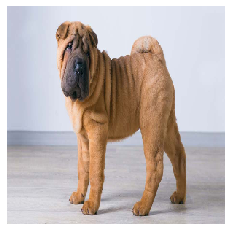

'chow'

In [ ]:
# image path
!wget https://www.dogbreedslist.info/uploads/allimg/dog-pictures/Miniature-Shar-Pei-2.jpg
img_path="/content/drive/My Drive/Colab Notebooks/dog/Miniature-Shar-Pei-2.jpg" # dog
predict_from_image(img_path)